
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder

from config import *
from src.match_names import name_fbref_to_fpl, neutralize_name

# Loading data
Data consists of all PL players logs for 2021-22 and 2022-23 seasons\
A single log is just a summary of player performance in a particular match

In [3]:
# loading csv
df_original = pd.read_csv('data/previous/FPL_logs.csv')

df = df_original.copy()

In [4]:
df_original.columns

Index(['Date', 'Day', 'Venue', 'Team', 'Opponent', 'Name', 'Start', 'Pos',
       'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'T_att', 'T_succ',
       'Season', 'WDL', 'Team_score', 'Opp_score', 'Team_CS', 'Was_home', 'GW',
       'Clean_name', 'FPL_name', 'FPL_team', 'FPL_opp_team', 'Name_original',
       'FPL_pos', 'FPL_ast', 'Bonus', 'Bps', 'Player_CS', 'Creativity',
       'Element', 'Fixture', 'Player_GC', 'Goals_scored', 'ICT_index',
       'Influence', 'Kickoff_time', 'FPL_min', 'Own_goals', 'Penalties_missed',
       'Penalties_saved', 'Saves', 'Selected', 'Threat', 'FPL_points',
       'Transfers_balance', 'Transfers_in', 'Transfers_out', 'Price', 'FPL_GW',
       'xP', 'FPL_xA', 'FPL_xGI', 'FPL_xG', 'FPL_xGC', 'Opp_rating',
       'Team_rating', 'Min_points', 'Avg_FPL_points'],
      dtype='object')

In [5]:
df_original["Name"].unique().size

461

In [6]:
df.shape

(18674, 81)

In [7]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [8]:
df = df[~df["FPL_pos"].isin(["GK"])]

In [9]:
df["Season"].unique()

array(['2021-22', '2022-23', '2023-24'], dtype=object)

In [10]:
df = df[df["Season"].isin(['2021-22', '2022-23'])]
# df = df[df["FPL_pos"].isin(['GK'])]

In [11]:
df = df.sort_values(by=["Name", "Date"])

# Feature selection
Model will use a set of standard features and moving averages for some other feature values. In this case we will use moving averages for last 2, 4 and 30 gameweeks.

In [12]:
rolling_gameweeks = [2, 4]
# rolling_gameweeks = [5]

# to_predict = "FPL_points"
to_predict = "xP"
standard_features = [
             "Was_home", # Home/Away
             # "Team_rating", "Opp_rating", 
             "Rating_difference", # Team ratings
             # "Price", # FPl price
             # "Transfers_balance",
             # "Transfers_result"
             "Avg_FPL_points",
             # "Avg_xP",
             # 'Avg_FPL_points_venue', 
             # "Was_home_xP",
             # "RD_xP",
             # "Team_xP",
             # "Opp_xP"
             ]
features_to_roll = [
                # "Min", 
                # "Start", # time played
                # 'Gls', 
                # 'Sh', 'SoT', # Goals
                # 'Ast', # Assists
                # 'CrdY', 'CrdR', # Cards
                # "xG", 'xA', # Expected
                # 'Team_CS', # Defence
                # 'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "T_succ",
                # 'bonus', 'bps', # Bonus
                # 'ICT_index', # ICT
                # "FPL_points", 
                "xP"
                # "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name_original", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "FPL_pos", "FPL_points"]

In [13]:
# df[df["Name"] == "Erling-Haaland"]

# Feature engineering

In [14]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]
df["Transfers_result"] = df["Transfers_balance"] >= 0

In [15]:
df

,Date,Day,Venue,Team,Opponent,Name,Start,Pos,Min,Gls,...,FPL_xGI,FPL_xG,FPL_xGC,Opp_rating,Team_rating,Min_points,Avg_FPL_points,Rating_difference,Baseline_points,Transfers_result
0,2021-08-21,Sat,Home,Brighton,Watford,Aaron-Connolly,N,FW,45.0,0.0,...,NaN,NaN,NaN,1681.872192,1728.483398,NaN,0.555556,1.027714,1,False
1,2021-08-28,Sat,Home,Brighton,Everton,Aaron-Connolly,N,0,0.0,0.0,...,NaN,NaN,NaN,1780.006958,1738.980469,NaN,0.555556,0.976952,0,False
2,2021-09-19,Sun,Home,Brighton,Leicester City,Aaron-Connolly,N,0,0.0,0.0,...,NaN,NaN,NaN,1795.105225,1735.531982,NaN,0.555556,0.966814,0,False
3,2021-09-27,Mon,Away,Brighton,Crystal Palace,Aaron-Connolly,N,LM,15.0,0.0,...,NaN,NaN,NaN,1708.091675,1744.599365,NaN,0.555556,1.021373,1,False
4,2021-10-02,Sat,Home,Brighton,Arsenal,Aaron-Connolly,N,0,0.0,0.0,...,NaN,NaN,NaN,1844.299316,1739.216797,NaN,0.555556,0.943023,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18636,2023-02-05,Sun,Home,Tottenham,Manchester City,Yves-Bissouma,N,"CM,AM",7.0,0.0,...,NaN,NaN,NaN,2025.632446,1858.188477,NaN,1.724138,0.917337,1,False
18637,2023-05-06,Sat,Home,Tottenham,Crystal Palace,Yves-Bissouma,N,0,0.0,0.0,...,NaN,NaN,NaN,1749.267944,1813.097046,NaN,1.724138,1.036489,0,False
18638,2023-05-13,Sat,Away,Tottenham,Aston Villa,Yves-Bissouma,N,CM,30.0,0.0,...,NaN,NaN,NaN,1800.410522,1819.116089,NaN,1.724138,1.010390,1,False
18639,2023-05-20,Sat,Home,Tottenham,Brentford,Yves-Bissouma,Y,CM,90.0,0.0,...,NaN,NaN,NaN,1793.386230,1816.587036,NaN,1.724138,1.012937,1,True


In [16]:
def add_linear_fixtures(df):
    df["Was_home_xP"] = df["Avg_FPL_points"] * df["Was_home"]
    df["RD_xP"] = df["Avg_FPL_points"] * df["Rating_difference"]
    df["Team_xP"] = df["Avg_FPL_points"] * df["Team_rating"]
    df["Opp_xP"] = df["Avg_FPL_points"] * df["Opp_rating"]
    df['Avg_xP'] = df.groupby('Name_original')['xP'].transform('mean')
    df.loc[df["Was_home"] == True, 'Avg_FPL_points_venue'] = df[df["Was_home"] == True].groupby('Name_original')['FPL_points'].transform('mean')
    df.loc[df["Was_home"] == False, 'Avg_FPL_points_venue'] = df[df["Was_home"] == False].groupby('Name_original')['FPL_points'].transform('mean')
    
    return df

In [17]:
df = add_linear_fixtures(df)

In [18]:
def calculate_team_points(row):
    # win - 3 points
    if row['Team_score'] > row['Opp_score']:
        return 3
    # draw - 1 point
    elif row['Team_score'] == row['Opp_score']:
        return 1
    # loss - 0 points
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [19]:
def add_rolling_features(df, standard_features, features_to_roll):
    features = standard_features
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        # print(form_means[form_means["Name"] == "Erling-Haaland"])
        form_means = form_means.fillna(method='bfill') # slightly incorrect, better to drop Nan
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df.reset_index(), form_means], axis=1)
        # df = df.merge(form_means, left_index=True, right_index=True)
        df = df.drop([col for col in df.columns if col.startswith('level')], axis=1)
        
    return df.reset_index(), features

In [20]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [21]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [22]:
df = label_encoding(df, "Start")

In [23]:
df, features = add_rolling_features(df, standard_features, features_to_roll)

In [24]:
# df, features = ohe(df, ["FPL_pos"], features)
# if "GK" in df.columns:
#     df = df.drop("GK", axis=1)
#     features.remove("GK")

In [25]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + [to_predict])]

In [26]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [27]:
# dropping NaNs
df = df.dropna(axis=0)

In [28]:
# df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [29]:
df.columns

Index(['Avg_FPL_points', 'FPL_points', 'FPL_pos', 'GW', 'Name_original',
       'Opp_rating', 'Opponent', 'Rating_difference', 'Season', 'Team',
       'Team_rating', 'Was_home', 'xP', 'xP_2', 'xP_4'],
      dtype='object')

In [30]:
df.shape

(15929, 15)

In [31]:
df = df[~df["FPL_pos"].isin(["GK"])] # only outfield players

In [32]:
df.shape

(15929, 15)

# Data split into train and valid
Let's take entire 2021-22 season and 30 first gameweeks of 2022-23 season as training data and 8 last gameweeks of that season as valid data (~10% of all rows).

In [33]:
def shrink_df_to_top_players(df, n_players, min_fixtures):
    # Calculate average scores
    average_scores = df.groupby('Name_original')[to_predict].mean()
    
    # Calculate player counts
    player_counts = df['Name_original'].value_counts()
    
    # Filter out players with less than min_fixtures occurrences
    popular_players = player_counts[player_counts >= min_fixtures].index
    
    print("Unique players with min_fixtures:", popular_players.size)

    # Sort players by average scores
    sorted_players = average_scores.sort_values(ascending=False)

    # Get the top n_players players
    top_popular_players = sorted_players[sorted_players.index.isin(popular_players)].head(n_players)

    # Filter the original DataFrame
    top_players_df = df[df['Name_original'].isin(top_popular_players.index)]
    
    print("Unique players left:", top_players_df['Name_original'].unique().size)
    
    return top_players_df

In [34]:
CUT_OFF_GAMEWEEK = 31
SEASON_TO_PREDICT = "2022-23"

In [35]:
df_train = shrink_df_to_top_players(df, 550, 10)
# df_train["Name_original"].unique()

Unique players with min_fixtures: 355
Unique players left: 355


In [36]:
df = df.set_index(["Name_original", "Season", "GW"], drop=False)

In [37]:
# training data
X_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][features].reset_index(drop=True)
y_train = df_train[((df_train["Season"] < SEASON_TO_PREDICT) | (df_train["GW"] <= CUT_OFF_GAMEWEEK - 1))][to_predict].reset_index(drop=True)

In [38]:
# only 31st gameweek
X_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [39]:
# all remaining gameweeks
X_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) ]["FPL_points"].reset_index(drop=True)

In [40]:
X_train.shape, X_test.shape, X_test_all_remaining.shape

((13868, 5), (247, 5), (2003, 5))

# Model

In [41]:
# model = GradientBoostingRegressor(random_state=42)
# model = XGBRegressor(
#         random_state=42,
#         n_estimators=500,
#         # early_stopping_rounds=5,
#         learning_rate=0.2
#     )
model = LinearRegression()
# model = RandomForestRegressor(random_state=42)

In [42]:
%%time
model.fit(
        X_train, 
        y_train,
        # eval_set=[(X_test_all_remaining, y_test_all_remaining)],
        # verbose=False
    )

CPU times: total: 0 ns
Wall time: 3.99 ms


LinearRegression()

In [43]:
features

['Was_home', 'Rating_difference', 'Avg_FPL_points', 'xP_2', 'xP_4']

In [44]:
# model.coef_

# Getting predictions

In [45]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    if all_remaining:
        df_predictions = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + [to_predict] + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [46]:
preds, predictions = get_predictions(model, df, X_test)

In [47]:
preds_all_gameweeks, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

# Custom metric
Such models are usually used to compare players and decide who to pick for upcoming gameweek(s). For each player pair in a subset of players model can either predict the outcome well (e.g. player A scores more than player B and model predicts exactly that) or predict wrongly (e.g. player A scores more than player B but model predicts player B > player A). Pairwise_accuracy returns the percentage of corrected predicted pairs. Pairwise_accuracy_topX is a variation of this metric calculated only for X highest scoring players of last two seasons.

In [48]:
def get_top_performer_names(df, no_top, no_gws):
    # takes no_top players that recorded highest average FPL points in no_gws last gameweeks
    return df.reset_index(drop=True).groupby("Name_original")[to_predict].mean().groupby("Name_original").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [49]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [50]:
def pairwise_accuracy_topX(model, df, top_x, all_gw=False):
    # pairwise_accuracy for top_X players
    if all_gw:
        top_performers = df[(df["GW"] == CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]
    else:
        top_performers = df[(df["GW"] >= CUT_OFF_GAMEWEEK) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name_original"].isin(get_top_performer_names(df, top_x, 50)))]

    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

# Evaluation

In [51]:
def evaluate(model, df, predictions, y_true, all_gw=False):
    # function to calculate different metrics for a given model
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20, all_gw)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100, all_gw)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

In [52]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [53]:
# next gameweek
evaluate(model, df, predictions, y_test, all_gw=False)

MAE: 1.4465675330482493
MSE: 4.011342562443853
Pairwise accuracy: 0.6678845330963431
Pairwise accuracy @TOP100: 0.570181314450019
Pairwise accuracy @TOP20: 0.5603049618797651


In [54]:
# all remaining gameweeks
evaluate(model, df, predictions_all, y_test_all_remaining, all_gw=True)

MAE: 2.0159081913978825
MSE: 7.889036659627848
Pairwise accuracy: 0.5543722378470257
Pairwise accuracy @TOP100: 0.5650896267998825
Pairwise accuracy @TOP20: 0.6862745098039216


In [55]:
pred_sum = preds_all_gameweeks["Pred"].sum()
fpl_sum = preds_all_gameweeks["FPL_points"].sum()
xp_sum = preds_all_gameweeks["xP"].sum()

pd.DataFrame([pred_sum, fpl_sum, xp_sum], index=["Pred", "FPL", "xP"], columns=["Sum"])

,Sum
Pred,5334.655273
FPL,4881.000000
xP,5280.700000


In [56]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [57]:
features

['Was_home', 'Rating_difference', 'Avg_FPL_points', 'xP_2', 'xP_4']

In [58]:
len(features)

5

# Predictions - next gameweek only

In [59]:
preds.head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
73,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042847,FWD,12,9.8,7.623411
178,Mohamed Salah,31,2022-23,Liverpool,Leeds United,0.0,1925.248169,1694.963013,MID,14,7.5,6.653343
138,Kevin De Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042847,MID,8,6.5,6.397073
162,Gabriel Martinelli Silva,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,MID,5,4.6,5.655829
98,Ivan Toney,31,2022-23,Brentford,Wolves,0.0,1782.324097,1717.951782,FWD,2,4.0,5.307372
190,Ollie Watkins,31,2022-23,Aston Villa,Newcastle Utd,1.0,1801.513550,1876.322510,FWD,16,10.5,5.190524
220,Solly March,31,2022-23,Brighton,Chelsea,0.0,1826.634155,1827.184204,MID,5,2.8,5.148453
85,Gabriel Fernando de Jesus,31,2022-23,Arsenal,West Ham,0.0,1946.847900,1751.608521,FWD,7,7.2,5.032386
99,Jack Grealish,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042847,MID,7,4.5,4.849432
29,Bruno Borges Fernandes,31,2022-23,Manchester Utd,Nott'ham Forest,0.0,1878.940308,1635.660278,MID,3,8.1,4.767774


In [60]:
# preds[preds["Team"] == "Manchester City"].head(20)

# Predictions - all remaining gameweeks

In [61]:
preds_all_gameweeks.head(15)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,xP,Pred
607,Erling Haaland,35,2022-23,Manchester City,Leeds United,1.0,2069.102051,1662.209595,FWD,2,6.0,8.366751
606,Erling Haaland,34,2022-23,Manchester City,Fulham,0.0,2064.563232,1717.714233,FWD,8,9.0,8.207132
1431,Mohamed Salah,37,2022-23,Liverpool,Aston Villa,1.0,1955.095703,1812.286377,MID,5,3.7,8.073615
605,Erling Haaland,33,2022-23,Manchester City,Arsenal,1.0,2057.953369,1928.582397,FWD,14,11.6,7.825072
604,Erling Haaland,31,2022-23,Manchester City,Leicester City,1.0,2060.531738,1722.042847,FWD,12,9.8,7.623411
608,Erling Haaland,36,2022-23,Manchester City,Everton,0.0,2071.091064,1694.975464,FWD,7,4.6,7.579300
1426,Mohamed Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1926.870483,1623.869141,MID,7,4.3,7.577377
1430,Mohamed Salah,36,2022-23,Liverpool,Leicester City,0.0,1944.225098,1709.140259,MID,12,10.2,7.575436
609,Erling Haaland,37,2022-23,Manchester City,Chelsea,1.0,2087.472656,1794.311890,FWD,1,1.4,7.332590
1429,Mohamed Salah,35,2022-23,Liverpool,Brentford,1.0,1940.118652,1782.053101,MID,10,10.6,7.311616


In [62]:
# preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Mohamed Salah"].sort_values(by=["GW"])

In [63]:
# preds_all_gameweeks[preds_all_gameweeks["Name_original"] == "Erling Haaland"].sort_values(by=["GW"])

# Saving to file

In [64]:
preds_all_gameweeks.to_csv("predictions/all_predictions.csv", index=False)

In [65]:
pickle.dump(model, open("models/GBR.pkl", 'wb'))

# Future preds

In [66]:
df_upcoming = pd.read_csv("data/upcoming/upcoming_fixtures.csv")

Columns (2,3,6,36,43,44,45,59,84,86,147,208) have mixed types.Specify dtype option on import or set low_memory=False.


In [67]:
df_upcoming = add_linear_fixtures(df_upcoming)

In [68]:
df_upcoming = df_upcoming[~df_upcoming[features].isnull().any(axis=1)] # for some reason 45 rows are missing some feature values

In [69]:
df_upcoming = df_upcoming[(df_upcoming["Season"] == CURRENT_SEASON) & (df_upcoming["GW"] >= NEXT_GAMEWEEK)].reset_index(drop=True)

In [70]:
X_test = df_upcoming[features]

In [71]:
def adjust_for_injuries(df):
    active_players = pd.read_csv("data/misc/active_players.csv")
    injured_players = active_players[active_players["chance_of_playing_next_round"] == 0]["name"].to_list()
    df.loc[df["Name_original"].isin(injured_players),"Pred"] = 0
    return df

In [72]:
def adjust_goalkeepers(df):
    gks = pd.read_csv("data/misc/goalkeepers.csv")
    gk_names = gks["Name"].to_list()
    gk_names = [name_fbref_to_fpl(neutralize_name(n)) for n in gk_names]
    # print(gk_names)
    df.loc[(df["FPL_pos"] == "GK") & ~(df["Name_original"].apply(neutralize_name).isin(gk_names)), "Pred"] = 0
    return df

In [73]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data and glues them to the rest of the dataframe
    predictions = model.predict(X)
    df_predictions = df[(df["Season"] == CURRENT_SEASON)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    preds = df_predictions[info + ["Pred"]]
    
    preds = adjust_goalkeepers(preds)
    preds = adjust_for_injuries(preds).sort_values(by=["Pred"], ascending = False)
    
    return preds

In [74]:
# df_upcoming[df_upcoming["Name_original"] == "Erling Haaland"][["Name_original", "Was_home", 'Avg_FPL_points_venue']]

In [75]:
preds = get_predictions(model, df_upcoming, X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
# next gameweek
preds[preds["GW"] == NEXT_GAMEWEEK].head(30)

,Name_original,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,FPL_pos,FPL_points,Pred
4610,Erling Haaland,4.0,2023-24,Manchester City,Fulham,1.0,2083.702148,1732.639404,FWD,NaN,7.139089
11201,Mohamed Salah,4.0,2023-24,Liverpool,Aston Villa,1.0,1946.521606,1825.741455,MID,NaN,6.852045
2096,Bryan Mbeumo,4.0,2023-24,Brentford,Bournemouth,1.0,1835.573242,1660.290894,MID,NaN,6.407119
2410,Carlton Morris,4.0,2023-24,Luton,West Ham,1.0,1602.477417,1787.825562,FWD,NaN,6.097191
5412,Guglielmo Vicario,4.0,2023-24,Tottenham,Burnley,0.0,1829.239014,1722.952881,GK,NaN,6.032649
12459,Phil Foden,4.0,2023-24,Manchester City,Fulham,1.0,2083.702148,1732.639404,MID,NaN,5.533076
14059,Solly March,4.0,2023-24,Brighton,Newcastle Utd,1.0,1843.758179,1884.512817,MID,NaN,5.411561
2026,Bruno Borges Fernandes,4.0,2023-24,Manchester Utd,Arsenal,0.0,1865.755249,1927.032104,MID,NaN,5.393691
2130,Bukayo Saka,4.0,2023-24,Arsenal,Manchester Utd,1.0,1927.032104,1865.755249,MID,NaN,5.189804
10400,Martin Ødegaard,4.0,2023-24,Arsenal,Manchester Utd,1.0,1927.032104,1865.755249,MID,NaN,5.134376


In [99]:
n_gameweeks = 5
pivot = pd.pivot_table(preds[preds["GW"] < NEXT_GAMEWEEK + n_gameweeks], values='Pred', index=['Name_original', "FPL_pos"],
                       columns=['GW'], aggfunc=np.sum)
pivot['Summary'] = pivot.sum(axis=1)
pivot.columns = ['GW' + str(col).split(".")[0] for col in pivot.columns[:-1]] + ['Summary']
pivot = pivot.sort_values(by=["Summary"], ascending = False)
pivot.head(20)

,,GW4,GW5,GW6,GW7,GW8,Summary
Name_original,FPL_pos,,,,,,
Erling Haaland,FWD,7.139089,6.706162,7.198496,6.792357,6.578731,34.414835
Mohamed Salah,MID,6.852045,6.590046,6.886267,6.472218,6.459535,33.260111
Guglielmo Vicario,GK,6.032649,6.499190,5.862472,6.224828,6.153458,30.772598
Bryan Mbeumo,MID,6.407119,5.831282,6.376280,6.012838,5.846104,30.473623
Carlton Morris,FWD,6.097191,5.763659,6.163479,5.797735,6.066477,29.888541
Bruno Borges Fernandes,MID,5.393691,5.836618,5.567266,5.910670,5.843448,28.551693
Solly March,MID,5.411561,5.049708,5.611545,5.082488,5.364388,26.519690
Phil Foden,MID,5.533076,5.100148,5.592483,5.186344,4.972717,26.384768
Jarrod Bowen,MID,5.113992,5.100755,4.815534,5.460426,5.238018,25.728726


In [77]:
# points all season
pd.DataFrame(preds.groupby(["Name_original"])["Pred"].sum().sort_values(ascending=False)).head(30)

,Pred
Name_original,
Mohamed Salah,235.035323
Erling Haaland,235.030642
Guglielmo Vicario,216.127549
Bryan Mbeumo,207.829207
Carlton Morris,206.832958
Bruno Borges Fernandes,199.356288
Solly March,185.453749
Phil Foden,180.426181
Jarrod Bowen,179.751668


In [78]:
preds.to_csv("predictions/preds_next_season.csv", index=False)

# Feature importance and influence

In [79]:
explainer = shap.Explainer(model.predict, X_test[2000:3000])
shap_values = explainer(X_test[2000:3000])

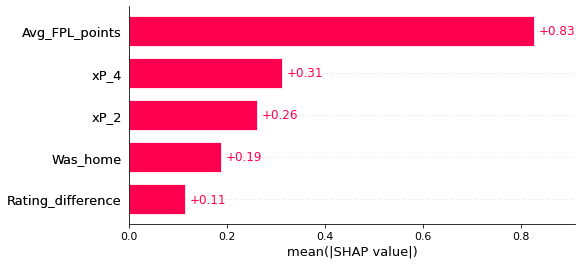

In [80]:
shap.plots.bar(shap_values, max_display=15)

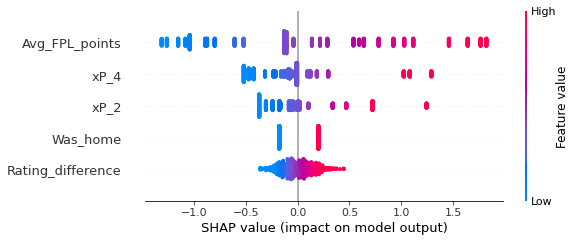

In [81]:
shap.plots.beeswarm(shap_values, max_display=15)

In [82]:
# # explaining Erling Haaland`s score in gameweek 31
# shap.plots.bar(shap_values[69], max_display=15)

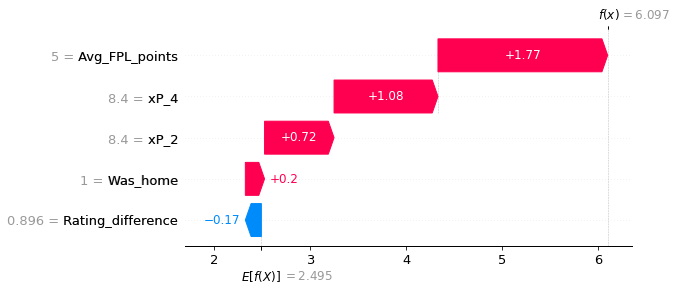

In [83]:
shap.plots.waterfall(shap_values[410])

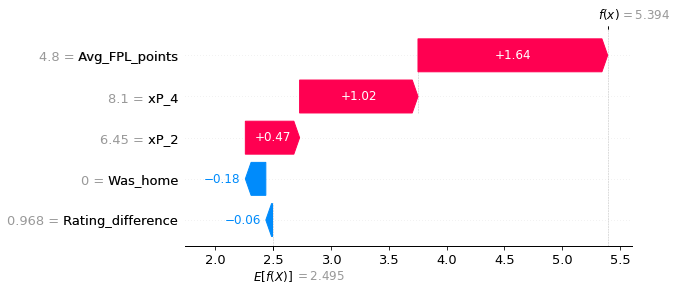

In [84]:
shap.plots.waterfall(shap_values[26])

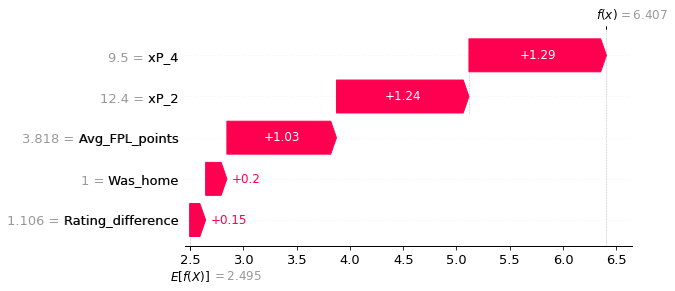

In [85]:
shap.plots.waterfall(shap_values[96])